# Frequentist & Bayesian Statistics With Py4J & PyMC3
-----

__[1. Introduction](#first-bullet)__

__[2. Sampling A Distribution Written In Scala Using Py4J](#second-bullet)__

__[3. The Maximum Likelyhood Estimator](#third-bullet)__

__[4. Confidence Intervals From Fisher Information](#fourth-bullet)__

__[5. Bayesian Esimatators & Credible Intervals With PyMC3](#fifth-bullet)__

__[6. Connecting The Two Methods](#sixth-bullet)__


## Introduction <a class="anchor" id="first-bullet"></a>
-------------

In this post I want to go back to the basics of statistics, but with an advanced spin on things. By "advanced spin" I mean, both from in terms of mathematics and computational techniques. The topic I'll dive into is:

    Estimating a single parameter value from a distribution and then quantifying the uncertantity in the estimate.
    
In general I will take two approaches to quantitfying the uncertainity in the estimate, the first of which is [frequentist](https://en.wikipedia.org/wiki/Frequentist_inference) and second that is [Bayesian](https://en.wikipedia.org/wiki/Bayesian_statistics). I was originally inspired by [Jake VanderPlas' post](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/) and admit, I am not very seasoned using Bayesian methods. That's why I'll be sticking to a simple example of estimating the mean rate or 𝜆 in a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution#) from sampled data.  

From the computational perspective, I wanted to do something different and decided to write the probability distribution for generating the data in [Scala](https://www.scala-lang.org/), but then use it with Python. Why did I do this? Well, I like Scala and enjoyed the challenge of writing a Poisson distribution using a functional approach. I also wanted to learn more about how to use [Py4J](https://www.py4j.org/) which can be used to work with functions and objects in the [JVM](https://en.wikipedia.org/wiki/Java_virtual_machine) from Python. [Apache Spark](https://spark.apache.org/) actually uses Py4J in PySpark to write Python wrappers for their Scala API. I've used both PySpark and Spark in Scala extensively in the past and doing this project gave me an opportunity to understand how PySpark works better.

The source code for this project can be found [here](https://github.com/mdh266/BayesMLE).

Let's get into how I wrote the Poisson distribution in Scala and used it from Python to sample data.

## 2. Sampling A Distribution Written In Scala Using Py4J <a class="anchor" id="second-bullet"></a>
---------------

I wrote a [Poisson distribution in Scala](https://github.com/mdh266/PoissonDistributionInScala) so that I could sample data from it to estimate the mean rate $\lambda$ of that distribution. The Poisson distribution is a probability distribution for a random variable $y \, \in \, \mathbb{Z}_{+}$ that represents some count phenomena, i.e. a number of non-negative integer occurences in some fixed time frame.  For example the number of trains passing through a station per day or the number of customers that visit a website per hour can be modeled with Poisson distribution. The mathematical form of the distribution is,

$$ p(y \, = \, k)  \; = \; \frac{\lambda^{k} e^{-\lambda} }{k!} $$

The parameter $\lambda \, \in \, \mathbb{R}_{+}$ is the rate variable, i.e. the true number of customers that visit the website per hour and can be any non-negative real valued number.


The first step in this project was to create the Poisson class. I did this in a previous [project](https://github.com/mdh266/PoissonDistributionInScala), however, one key difference is for Py4J the return value of any public function needs to be Java object. Specifically the [sample](https://github.com/mdh266/BayesBootstrapMLE/blob/main/src/main/scala/Poisson.scala) method needs to return a Java List ([java.util.List[Int]](https://www.javatpoint.com/java-list)) of integers. I originally tried returning a [Scala List](https://www.scala-lang.org/api/current/scala/collection/immutable/List.html) which worked fine in pure Scala, but when returning the list to Python I got a generic "Java Object" and realized Py4J was only able to serialize specific datatypes between Python and the JVM.


In order to use this class from Python with Py4J I needed to do three things to the Scala code:

1. Create a [Gateway Server](https://www.py4j.org/_static/javadoc/index.html?py4j/GatewayServer.html)
2. Create a class entrypoint to allow for setting object attributes outside of the constructor
3. Package the code as a jar using a build tool such as [Maven](https://maven.apache.org/) or [SBT](https://www.scala-sbt.org/)


The first step is pretty straight forward to from the [Py4J Documentation](https://www.py4j.org/getting_started.html) and is in the [Main.Scala](https://github.com/mdh266/BayesBootstrapMLE/blob/main/src/main/scala/Main.scala) object. However, in order to accommodate the use of [Docker]() I had to adapt the address for the [GatewayServer](https://www.py4j.org/_static/javadoc/index.html?py4j/GatewayServer.html) based on this [discussion on GitHub](https://github.com/bartdag/py4j/issues/360):

    import java.net.InetAddress
    import py4j.GatewayServer

    object Main {
        def main(args: Array[String]) = {
            System.setProperty("java.net.preferIPv4Stack", "true");
            val addr = InetAddress.getByName("0.0.0.0")
            val app = new PoissonEntryPoint()
            val builder = new GatewayServer.GatewayServerBuilder(app)
            builder.javaAddress(addr);
            val server = builder.build();
            server.start()
            println("Gateway Server Started")
        }
    }

The [GatewayServer](https://www.py4j.org/_static/javadoc/py4j/GatewayServer.html) in the author's own words *it allows Python programs to communicate with the JVM through a local network socket.*  The GatewayServer takes an *entrypoint* as a parameter which can be any object (see [here](https://www.py4j.org/getting_started.html#writing-the-python-program) for more info). However, the entrypoint doesn't really offer a way for us to pass the $\lambda$ value from [Python](https://www.py4j.org/getting_started.html#writing-the-python-program) to the Poisson constructor in Scala. To get around this issue I created a [PoissonEntryPoint](https://github.com/mdh266/BayesBootstrapMLE/blob/main/src/main/scala/PoissonEntryPoint.scala) case class:

    case class PoissonEntryPoint() {

        def Poisson(lambda : Double) : PoissonDistribution = {
            new PoissonDistribution(lambda)
        }
    }

This case class really just acts a [Singleton](https://docs.scala-lang.org/tour/singleton-objects.html), but is a class instead of an object. The point of the `PoissonEntryPoint` class is simply to be able to create a Poisson class with a specific $\lambda$ value after starting the GatewayServer.  

Now let's talk about how the project is structured and how to package it for use.  The project structure is:

    src/
       main/
           scala/
               Main.scala
               PoissonDistribution.scala
               PoissonEntryPoint.scala
    pom.xml
    

The `pom.xml` file is called the [project object model](https://maven.apache.org/guides/introduction/introduction-to-the-pom.html) and is a file that contains all the instructions for [Maven](https://maven.apache.org/). I won't go into the details here, but I will say that Maven is a Java build tool to compile and package code and [SBT](https://www.scala-sbt.org/) is the Scala equivalent build tool. Since Scala is a [JVM language](https://en.wikipedia.org/wiki/List_of_JVM_languages) we can use either build tool and I went with Maven since I'm more familiar with it and because it was much easier to find examples with Py4J using Maven than with SBT.

To package the code into a [uber jar](https://stackoverflow.com/questions/11947037/what-is-an-uber-jar), use the command:

    mvn package 
    
Then we can start our our Py4J Web server with the command:

    java -jar target/poisson-1.0-jar-with-dependencies.jar
    
We can test that the server is running on the default port 25333 on your local machine with the command,

    nc -vz 0.0.0.0 25333
    
You should see,
    
    Connection to 0.0.0.0 port 25333 [tcp/*] succeeded!

Now we can start up our Jupyter notebook and connect Python to the JVM with the following code taken directly from [Py4J's](https://www.py4j.org/index.html#) home page. This involves setting up the [JavaGatway](https://www.py4j.org/py4j_java_gateway.html) which is the *main interaction point between a Python VM and a JVM*. When running on your local machine this is simple, however, in order to use the my Poisson Distribution and Jupyter Lab within [Docker Compose](https://docs.docker.com/compose/) I had to pass the appropriate [GatewayParameters](https://www.py4j.org/py4j_java_gateway.html#py4j.java_gateway.GatewayParameters) which specify the address for the Scala [GatewayServer](https://www.py4j.org/_static/javadoc/py4j/GatewayServer.html) (the `py4jserver` service in Docker compose) and the port it uses. In addition I had to pass the [CallbackServerParameters](https://www.py4j.org/py4j_java_gateway.html#py4j.java_gateway.CallbackServerParameters) which specify the address for this notebook (the `jupyter` service in Docker compose) as well as the port it uses. 

The callback server allows the JVM to call back Python objects as discussed [here](https://www.py4j.org/advanced_topics.html#implementing-java-interfaces-from-python-callback).  I definitely had to have an friend that knows DevOps help figure this one out, but it doesnt add too much complexity to the basic Py4J example:

In [2]:
from py4j.java_gateway import JavaGateway, GatewayParameters, CallbackServerParameters

gateway = JavaGateway(
    gateway_parameters=GatewayParameters(address='py4jserver', port=25333),
    callback_server_parameters=CallbackServerParameters(address='jupyter', port=25334)
)

app = gateway.entry_point

The app is now the instantiated [PoissonEntryPoint class](https://github.com/mdh266/BayesMLE/blob/main/src/main/scala/PoissonEntryPoint.scala).  We can see the class type in Python

In [2]:
type(app)

py4j.java_gateway.JavaObject

As well as looking at the methods for the class:

In [3]:
dir(app)

['Poisson',
 'apply',
 'canEqual',
 'copy',
 'equals',
 'getClass',
 'hashCode',
 'notify',
 'notifyAll',
 'productArity',
 'productElement',
 'productIterator',
 'productPrefix',
 'toString',
 'unapply',
 'wait']

We can see `Poisson` class method! Since PoissonEntryPoint is a [case class](https://docs.scala-lang.org/tour/case-classes.html) it comes with a number of default methods just like a [data class](https://realpython.com/python-data-classes/) in Python.

We can then create a Poisson class instance and see that the value of $\lambda$ is 3.0:

In [4]:
p1 = app.Poisson(1.0)

We can then instantiate another Poisson object:

In [5]:
p2 = app.Poisson(3.0)

Note that the [PoissonEntryPoint](https://github.com/mdh266/BayesBootstrapMLE/blob/main/src/main/scala/PoissonEntryPoint.scala) class has a function `Poisson` that returns a specific [PoissonDistribution](https://github.com/mdh266/BayesBootstrapMLE/blob/main/src/main/scala/PoissonDistribution.scala) object that was initailized with the value $\lambda$. It is important that $\lambda$ is not an attribute of the [PoissonEntryPoint](https://github.com/mdh266/BayesBootstrapMLE/blob/main/src/main/scala/PoissonEntryPoint.scala) othwerwise we would not get the seperate values of $\lambda$'s:

In [6]:
p1.getLambda()

1.0

In [7]:
p2.getLambda()

3.0

The really nice thing about Py4J *is that you can treat objects in the JVM as if they are Python objects.* For instance we can see the methods in the object:

In [8]:
dir(p1)

['$anonfun$cdf$1',
 '$anonfun$getSum$1',
 '$anonfun$invCDF$1',
 '$anonfun$invCDF$2',
 '$anonfun$invCDF$3',
 '$anonfun$invCDF$4',
 '$anonfun$sample$1',
 '$anonfun$uniform$1',
 '$lessinit$greater$default$1',
 'cdf',
 'equals',
 'getClass',
 'getLambda',
 'getSum',
 'hashCode',
 'invCDF',
 'notify',
 'notifyAll',
 'prob',
 'sample',
 'setLambda',
 'toString',
 'uniform',
 'wait']

We can then just use the methods in the [PoissonDistribution](https://github.com/mdh266/BayesBootstrapMLE/blob/main/src/main/scala/PoissonDistribution.scala) object just like they would be used directly in Scala. For instance we can get the probability of $y=1$ when $\lambda = 3$:

In [9]:
p1.prob(1)

0.36787944117144233

Now let's generate a random samle from the Poisson object:

In [6]:
sample = p1.sample(1000)

In [11]:
sample[:3]

[2, 1, 1]

It looks like Py4J returns a Python list while the [PoissonDistribution class](https://github.com/mdh266/BayesBootstrapMLE/blob/main/src/main/scala/PoissonDistribution.scala) returns a  `java.util.List[Int]`:

In [12]:
type(sample)

py4j.java_collections.JavaList

We can then convert it to a Python list

In [13]:
type(list(sample))

list

Py4J can only serialize specific Java objects back to Python, but I think that's still awesome!  This is also why I needed to convert to from a Scala `List[Int]` to a `java.util.List[Int]`, without it the returned object would just be a generic `Java Object` and I wouldnt be able to access its contents.

Now let's visualize the Poission distribution for different values of $\lambda$

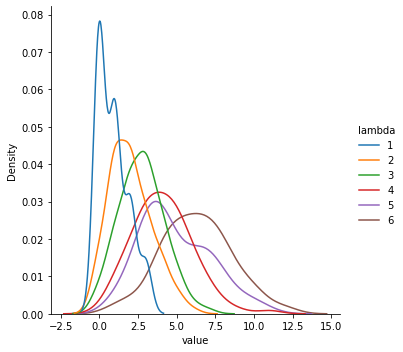

In [30]:
import pandas as pd
import seaborn as sns

df = pd.melt(
        pd.DataFrame({
            '1':list(app.Poisson(1.0).sample(100)),
            '2':list(app.Poisson(2.0).sample(100)),
            '3':list(app.Poisson(3.0).sample(100)),
            '4':list(app.Poisson(4.0).sample(100)),
            '5':list(app.Poisson(5.0).sample(100)),
            '6':list(app.Poisson(6.0).sample(100))
        }),
        var_name=["lambda"]
)

sns.displot(df, x="value", hue="lambda", kind='kde', height=5)

Note that the negative values are not real and an artifact caused by interpolation with [Kernel Density Esimation](https://en.wikipedia.org/wiki/Kernel_density_estimation), same with the wiggles.

We can verify this the former,

In [31]:
df.query("value < 0")

,lambda,value


Now let's get into the Maximum Likelyhood Estimator for $\lambda$ using the distribution `p1`.

## 3. The Maximum Likelyhood Estimator <a class="anchor" id="third-bullet"></a>
---------- 

First what is the difference between a statistic and an estimator?  A **statistic** is any function of a sample.  An **estimator** is any function of a sample that is used to estimate a population parameter.  The **maximum likelyhood estimator** is the value of a population distribution $\lambda$ that maximizes the probability of observing the sample.  


We can find the MLE from a random sample $y_1, y_2, \, \ldots \,, y_{n}$ from $f(y \, \vert \, \lambda)$ by defining the **likelyhood function**,

$$ L(\lambda  \, \vert \, y_1, \, y_2, \, \ldots, \, y_n)  \; = \; \prod_{i=1}^{n}f(y_{i} \, \vert \, \lambda) $$


Then we can find the MLE $\widehat{\lambda}$ such that, 

$$ 
\hat{\lambda}_{n} \; = \; \max_{\lambda} \, L(\lambda \, \vert \, y_1, y_2, \ldots, \, y_n)
$$

From calculus we know that we can find the maximum (or minimum) of any function by solving,

$$ 
\frac{\partial L(\lambda \, \vert y_1, y_2, \ldots, y_n)}{\partial \lambda}  \; = \; 0 
$$


for $\lambda$.  The MLE has many important properties, the most important in my mind are some are,

1. It is a consistent estimator.
2. It is invariant, so that if $\widehat{\lambda}$ is the MLE for $\lambda$, then for any function $\tau(\lambda)$, the MLE for $\tau(\lambda)$ is $\tau(\widehat{\lambda})$.
3. The MLE is an asymptotically normal estimator.  That is $\widehat{\lambda} \; \sim \; N(\lambda, \, \mathcal{I}^{-1})$. 

To explain the first property we, must note that since an estimator is a function of the sample space, it is also a [random variable](https://en.wikipedia.org/wiki/Random_variable).  Let $X_1, \, \ldots, \, X_n$ be a sequence of random variables then $X_{i} \; \xrightarrow{\mathcal{P}} \; X$ if,

$$\forall \epsilon > 0, \; \lim\limits_{n \rightarrow \infty} P(\vert X_i - X \vert > \epsilon ) \; = \; 0$$ 

then we say the random variable [converges in probability](https://en.wikipedia.org/wiki/Convergence_of_random_variables). For an estimator this property of convergence is called **consistency**. Consistency is a necessary condition of any estimator in statistics and basically signifies that estimator eventually settles down to constant or some distribution of values. 

The second property of the MLE allows us to transform our likelyhood function into one that is often easier to calculate the MLE with, i.e. the log-likelyhood function. That is the MLE, $\hat{\lambda}$ will satisfy, 

$$ \frac{\partial \log(L(\lambda \, \vert y_1, \, \ldots, y_n ))}{\partial \lambda}  \; = \; 0 $$


The third property of the MLE, of asymptotic normality, is helpful in modeling since your standardized residuals are normal. Hence the sum of squares of the residuals are $\chi^2$ distributed.  This allows us to define confidence intervals around of estimates. The term $\mathcal{I}$ is the [Fisher Information](https://en.wikipedia.org/wiki/Fisher_information) and will be discussed in the next section.


For the Poisson distribution the likelyhood function is,

$$
\begin{align} L(\lambda  \, \vert y_1, \, y_2, \, \ldots, \, y_n)  
\; &= \; 
\prod_{i=1}^{n} \frac{e^{-\lambda} \, \lambda^{y_i}} {y_i!} \newline
&= \; 
e^{-n \, \lambda} \lambda^{n \, \bar{y}_{n}}  \frac{1} {\prod_{i=1}^{n} y_i!}
\end{align}
$$

We take the log of both sides and then setting the derivative equal to zero we find


$$
- n  \,  + \, \frac{n \, \bar{y}_{n}}{\widehat{\lambda}} \, = \, 0
$$

Then solving for $\hat{\lambda}$ we find the MLE is,


$$ \widehat{\lambda} \, = \, \bar{y}_{n} $$


In [9]:
from typing import List

def mle(sample: List[int]) -> float:
    converted = list(sample)
    return sum(converted) / len(converted)

lam = mle(p2.sample(1000))

print(f"lambda = {lam}") 

lambda = 2.97


Our estimate for $\lambda$ is pretty close to the true value of 3 which is correct for `p2`! 

Now, since the maximum likelihood estimator is the mean we know it satifies the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem),


$$ \hat{\lambda} _{n}\, = \, \bar{y}_{n} \; \xrightarrow{\mathcal{D}} \; N(\lambda,\lambda/n) $$

Hence we can repeatedly sample `p2` and compute the distribution of the MLE for various values of sample size $n$ to show how the MLE converges in distribution.

In [8]:
import numpy as np

In [72]:
# sample the MLE 100 times for each n = 10, 50, 100, 500, 1000
samples = [ [ mle(p2.sample(n)) for k in range(100)] for n in [10, 20, 50, 100, 200, 500, 1000]]

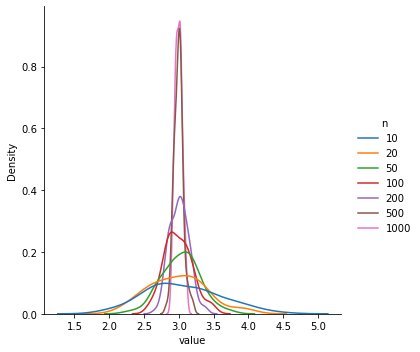

In [73]:
sample_df = pd.melt(
                pd.DataFrame(np.array(samples).T, 
                             columns=['10', '20', '50','100', '200', '500', '1000']),
                var_name=["n"]
)

# # plot the MLE for various value of sample size
sns.displot(sample_df, x="value", hue="n", kind="kde", height=5,)

As $n \rightarrow \infty$ we see the MLE $\bar{y}_{n}$ has a distribution that is more sharply peaked around $3$ and hence shows that the esimator is converging to the true value!

We have seen that the MLE $\hat{\lambda}_{n}$ converges to the true value of $\lambda$, but for any finite value of $n$ the esimator can be incorrect.  How do we measure our confidence in our estimae $\hat{\lambda}_{n}$?  The answer is using [confidence intervals](https://en.wikipedia.org/wiki/Confidence_interval).

## 3. Confidence Intervals From Fisher Information <a class="anchor" id="fourth-bullet"></a>
-------------------
Given a distribution $y_{i} \, \sim \, f(y \, \vert \, \alpha)$ for $i \, = \, 1, \ldots , n$ and the likelyhood function,

$$ L(\alpha \, \vert \, y_1, y_2, \ldots, y_n) \; = \; \prod_{i=1}^{n} \,  f(y_i \, \vert \, \alpha) $$

We define the [score statistic](https://en.wikipedia.org/wiki/Score_(statistics)) $S(\alpha)$ to be,

$$
S(\alpha) \; = \; \frac{d\log \left(L(\alpha \, \vert  \, y_1, y_2, \ldots, y_n) \right)}{d\alpha} 
$$

For a distribution from the [exponential family](https://en.wikipedia.org/wiki/Exponential_family) the score function satisfies,

$$
E_{y}[S] \; = \; 0
$$

Another important property of the score statistic is that it satisfies,

$$ S(\widehat{\alpha})  \; = \; 0$$

for the MLE $\widehat{\alpha}$.  This property can be used to compute the MLE using the so-called [scoring algorithm](https://en.wikipedia.org/wiki/Scoring_algorithm) which is equivalent to [Newton–Raphson method](https://en.wikipedia.org/wiki/Newton%27s_method). The later method is more frequently used in calculations as it is a general optimization method and has many efficient implmentations.

The [Fisher information](https://en.wikipedia.org/wiki/Fisher_information) is defined as,

\begin{align}
\mathcal{I} \; &= \; \text{Cov}[S] \\
& = \; \text{Var}[ S S^{T}] \\
& = \; E_y[ - S'] \\
 &= \; - E_{y} \left[ \frac{d^{2}\log \left(L(\alpha \, | \, y_1, y_2, \ldots, y_n) \right)}{d\alpha^{2}}  \right] 
\end{align}

One can show that the standard error for the maximum likelihood estimate $(\widehat{\alpha})$ will then be,

$$ \text{S.E.}(\widehat{\alpha}) \; = \; \mathcal{I}^{-1/2}$$


The curvature of the log-likelyhood at the MLE dictated by the Fisher information. If $L$ flat then the $\mathcal{I}$ is small, so the MLE is not stable or well-defined.  Larger Fisher information tells us the MLE is well defined and stable.


Asymptotic normality for the MLE implies,

\begin{equation}
 \widehat{\alpha} \; \sim \; N(\alpha, \, \mathcal{I}^{-1})
\end{equation}

These facts can be used to calculate confidence intervals for the MLE,

$$\text{CI}_{\alpha} \, = \, [ \widehat{\alpha} - Z_{\alpha/2} \, \mathcal{I}^{-1}/\sqrt{n}, \, \widehat{\alpha} + Z_{\alpha/2} \, \mathcal{I}^{-1} /\sqrt{n}]$$


The Fisher information for a Poisson distribution is,

$$ \mathcal{I} \, = \, 1/\lambda $$

This means for our MLE of the Poisson distribution the confidence interval will be: 

$$\text{CI}_{\hat{\lambda}} \, = \, [ \bar{y}_{n} - Z_{\alpha/2} \, \sqrt{\bar{y}_{n} / n}, \, \bar{y}_{n} + Z_{\alpha/2} \, \sqrt{\bar{y}_{n}/ n}]$$


We can then come up with a functin to compute the 94% confidence interval (most people choose 95%, but to be consistent with PyMC we use 94%) for the sample:

In [10]:
from typing import Tuple 

def ci(sample: List[int]) -> Tuple[float,float]:
    """
    Computes the 94% confidence interval for sampled
    data from a Poisson distribution
    """
    z = 1.88
    m = mle(sample)
    n = len(sample)
    return (m - z*np.sqrt(m/n), m + z*np.sqrt(m/n))

We can then get the MLE for the sampled data from Poisson(1.0)

In [11]:
mle(sample)

0.995

The 94% confidence interval is then,

In [12]:
ci(sample)

(0.9356979932885909, 1.054302006711409)

We can see that the confidence interval does contain the true $\lambda \, = \, 1$. Many people think a 94% confidence interval, $\text{CI}_{94}$, can be used to say that there is a 94% probability that the true $\lambda$ is in the confidence interval $\text{CI}_{94}$.  This interpetation is wrong, in frequentist methods, the parameter $\lambda$ is assumed to be a fixed, but unknown value. One cannot make probability statements about fixed values. 

The confidence interval is a function of the sample space and therefore a random variable. One can make probability statements about the confidence intervals. Indeed the correct interpretation is that if you are able to repeatedly re-sample the population distribution $f(y \, \vert \, \lambda)$ to form many confidence intervals $\text{CI}_{94}$, 94% of them would contain the true population parameter $\lambda$.

We can test this by creating a function which returns a boolean indicating whether or not the parameter `lam` is contained in the 94% confidence interval from the data `sample`:

In [13]:
def in_ci(lam: float, sample:  List[int]) -> bool:
    interval = ci(sample)
    return (lam >= interval[0] and lam <= interval[1])

We can then test this function:

In [14]:
in_ci(1, sample)

True

In [46]:
in_ci(3, sample)

False

Then we can loop over 1,000 confidence interval to see how many times they capture the true rate parameter:

In [48]:
count_in_ci = [1 if in_ci(1, p1.sample(1000)) else 0 for i in range(1000)]
print("Confidence interval captures true rate {}% of times".format(100*sum(count_in_ci)/len(count_in_ci)))

Confidence interval captures true rate 94.3% of times


This is nearly spot on to what the theory says!  Let's now move on to Bayesian methods!

# Bayesian Esimatators & Credible Intervals With PyMC3 <a class="anchor" id="fifth-bullet"></a>
-----------

In the frequentist approach the parameter we wish to estimation $\lambda$ is fixed, but unknown.  The observed data $\left\{ y_1, y_2, \ldots, y_n \right\}$ is assumed to be from a population $f(y \, \vert \, \lambda)$ and estimates about the value of the population paremeter $\lambda$ is obtained by using the maximum likelyhood. As we discussed above, probability statements about the unknown rate constant $\lambda$ don't make sense as its a fixed value and not random variable.  However, probability statements can be made about a confidence interval for $\lambda$. In the maximum likelyhood method, asympotic normality allows us to use confidence intervals as a way to quantify the uncertaintity in our estimator which was calculated from the data.

In contrast, in Bayesian statistics, $\lambda$ is not a fixed value, but assumed to have values coming from a probability distribution called the [prior](https://en.wikipedia.org/wiki/Prior_probability) $P(\lambda)$. This is often subjective and the choice of distribution for the prior often comes from domain knowledge.  The observed data $\left\{ y_1, y_2, \ldots, y_n \right\}$ is a sample taken from a population and used to update the prior distribution, now called the [posterior distribution](https://en.wikipedia.org/wiki/Posterior_distribution), $P(\lambda \, \vert \, y_1, y_2, \ldots, y_n )$. **Now we can formulate estimators for $\lambda$ and quanitify the uncertaintity in those esimates by directly using the posterior distribution.**

Let $P(y_1, y_2, \ldots, y_n \, \vert \, \lambda )$ be the sampling distribution then [Baye's theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) states,

$$ P(\lambda \, \vert \, y_1, y_2, \ldots, y_n)
 \; = \; 
\frac{ P ( y_1, y_2, \ldots, y_n \, \vert \, \lambda) \, P(\lambda)}{m(y_1, y_2, \ldots, y_n)}, \quad \text{and} \qquad m(y_1, y_2, \ldots, y_n) \; = \; \int P ( y_1, y_2, \ldots, y_n\, \vert \, \lambda) \, P(\lambda) \, d\lambda
$$
 

Where $m(y_1, y_2, \ldots, y_n)$ is called the marginal distribution and used for normalization. Bayes rule can also be rewritten as using the joint distibution $P(\lambda,\, y_1, y_2, \ldots, y_n)$:


$$ P(\lambda \, \vert \, y_1, y_2, \ldots, y_n)
 \; = \; 
\frac{ P(\lambda , y_1, y_2, \ldots, y_n)}{m(y_1, y_2, \ldots, y_n)}
$$

The [Bayesian estimator](https://en.wikipedia.org/wiki/Bayes_estimator) (often called the posterior mean) is taken the be the expected value over the the random variable $y$:
 
$$ \widehat{\lambda} \; = \; E_{\lambda \, \vert \, y}(\lambda \, \vert \, y_1, y_2, \ldots, y_n)$$
 

Until the advant of computers, statisticians were stuck with using [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior) in Bayesian methods since there are analytic solutions for the posterior distribution.

The conjugate prior for a Poisson distribution is a [Gamma distributed](https://en.wikipedia.org/wiki/Gamma_distribution) which for $\alpha, \beta > 0$ takes the form:

$$
P(\lambda \, \vert \, \alpha, \beta ) \; = \; \frac{\beta^{\alpha }}{(\alpha-1)! }  \, x^{\alpha-1} \, e^{-\beta y}
$$

A depiction of the Gamma distribution for various values of $\alpha$ and $\beta$ can be seen from [PyMC3's website](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma).

![](https://docs.pymc.io/api/distributions/continuous-6.png)

Then the posterior is [again a Gamma distribution](https://people.stat.sc.edu/Hitchcock/slides535day5spr2014.pdf), but with $\alpha^{\prime} \, = \, \alpha \, + \, n$ and $\beta^{\prime}  \, = \, \bar{y}_{n}, \,  \beta \, + \, n$. This leads to a posterior mean,


$$\hat{\lambda} \; = \; \frac{\alpha}{\beta \, + \, n} 
\, + \, \frac{ \bar{y}_{n}}{1 \, + \, \beta \, / \, n\, }$$

We can see that with little data (small $n$) our estimate we are closer to the prior mean ($\frac{\alpha}{\beta}$) while with lots of data (large $n$) we move towards the average $\bar{y}_{n}$.  

Let's see this convergence for ourselves! We can define the posterior mean function:

In [15]:
def posterior_mean(alpha: float, beta: float , sample: List[int]) -> float:
    n = len(sample)
    m = sum(sample) / n
    
    return alpha / (beta + n) + m  / (1 + beta / n)

Then define a 1,000 random samples of various sizes:

In [16]:
from random import randint
nums_samples = [randint(2,1000) for i in range(1000)]
nums_samples.sort()

We can the calculate and plot the posterior mean for the [Poisson-Gamma model](https://people.stat.sc.edu/Hitchcock/slides535day5spr2014.pdf)  using the data and $\alpha \, = \, 1$ and $\beta \, = \, 3$,

In [18]:
alpha = 3.0
beta = 1.0

<AxesSubplot:title={'center':'Covergence of Posterior Mean'}, xlabel='sample_size'>

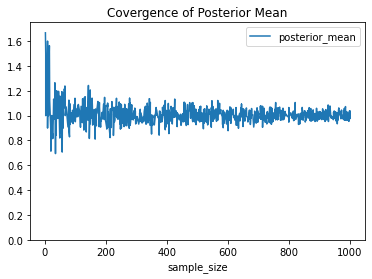

In [218]:
samples = [ posterior_mean(alpha=alpha, beta=beta, sample = p1.sample(n)) 
           for n in nums_samples]

(pd.DataFrame({
    "posterior_mean":samples, 
    "sample_size":nums_samples
}).plot(x="sample_size", 
        y="posterior_mean", 
        title="Covergence of Posterior Mean", 
        ylim=(0,1.75)))

Now let's talk about the confidence of this estimate. The anology of confidence in Bayesian esimation is called the [credible Interval](https://en.wikipedia.org/wiki/Credible_interval) which requires the full posterior. I wrote a function to plot the posterior for the sample from `p1` below:

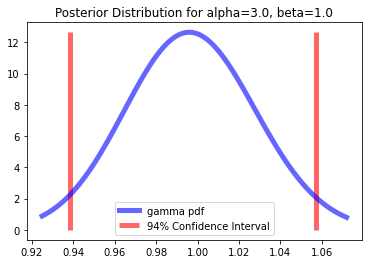

In [19]:
from gamma import posterior_distribution

posterior_distribution(alpha, beta, sample)

As we saw the Bayesian estimator requires the full posterior distribution. Without a conjugate prior Bayesian methods requires numerical approximation to the posterior which computationally expenisve. Despite the added complexity, Bayesian methods allow us to handle situations where we might not have much data and can often lead us to estimates with smaller variance. 

One approach to approximating the posterior distribution is to randomly sample the the prior distribution and then evaluate the joint distribution of the data. Once we have the posterior distribution we can then evaluate the expected value of $\lambda$.  One common method for random sampling is [Markov Chain Monte Carlo Methods](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) and Bayesian-MCMC methods can be used easily with [PyMC](https://docs.pymc.io/)!  

We begin by importing the library

In [23]:
import pymc3 as pm

Then define the model as the same Poisson-Gamma above, and sample it 5,000 times to get the expected mean:

In [21]:
with pm.Model() as model_1:
    λ = pm.Gamma('λ', alpha=3, beta=1)
    y = pm.Poisson('y', mu=λ, observed=list(sample))
    trace = pm.sample(5000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [λ]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 29 seconds.


We can then view the poserior distribution using the [ArviZ](https://arviz-devs.github.io/arviz/) library:

<AxesSubplot:title={'center':'λ'}>

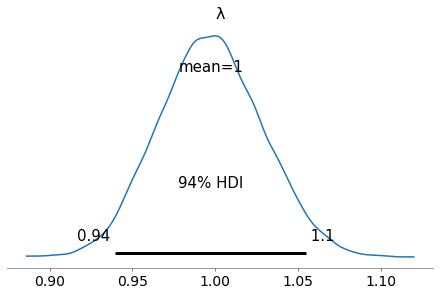

In [24]:
import arviz as az
az.plot_posterior(trace)

Same as before with the analytical posterior.

We should note that **Bayesian estimators are ALWAYS biased due to their choice of prior**, however, they can reduce the variance in our estimators.  This is will become evident in the next example where we show that another area where Bayesian method shine is when you have a limited amount of data, but a lot of domain knowledge.  

Say we only have 20 sample points, we can calculate the MLE:

In [36]:
mle(sample[-20:-1])

1.0526315789473684

Not too bad! However, the confidence interval is quite large,

In [37]:
ci(sample[-20:-1])

(0.6101254949789889, 1.4951376629157478)

Let's define our model to be a Poisson-Exponential model where the prior distribution is an [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution) pictured below from PyMC3 site:

![](https://docs.pymc.io/api/distributions/continuous-5.png)

Inconventially, these distributons both use $\lambda$ for their paramaters. Using a larger $\lambda$ in a prior gives us a larger sample space while a smaller $\lambda$ in the prior gives us a smaller sampling space. Let's choose a define the prior $\exp(-1)$ and sample it using MCMC methods 500 times.  We can then plot the posterior and the sampling space using the [plot_trace](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_trace.html) method:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [λ]


Sampling 2 chains for 2_000 tune and 500 draw iterations (4_000 + 1_000 draws total) took 12 seconds.


array([[<AxesSubplot:title={'center':'λ'}>,
        <AxesSubplot:title={'center':'λ'}>]], dtype=object)

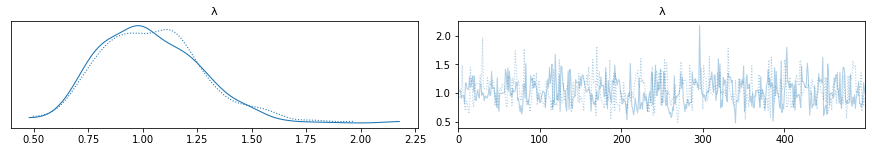

In [39]:
with pm.Model() as model_2:
    λ = pm.Exponential('λ', 1)
    y = pm.Poisson('y', mu=λ, observed=list(sample[-20:-1]))
    trace2 = pm.sample(500, tune=2000, cores=2, return_inferencedata=True)

az.plot_trace(trace2, var_names=['λ'])

We can then calculate the credible region and expected value

In [41]:
az.summary(trace2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
λ,1.037,0.231,0.662,1.488


Nearly the same as MLE, but we can see that the posterior isn't very well defined using only 500 MCMC steps. We can see that there seems to be some [autocorrelation in the sample space](https://www.coursera.org/lecture/introduction-to-pymc3/autocorrelation-and-effective-sample-size-YSW3x).


array([<AxesSubplot:title={'center':'λ\n0'}>,
       <AxesSubplot:title={'center':'λ\n1'}>], dtype=object)

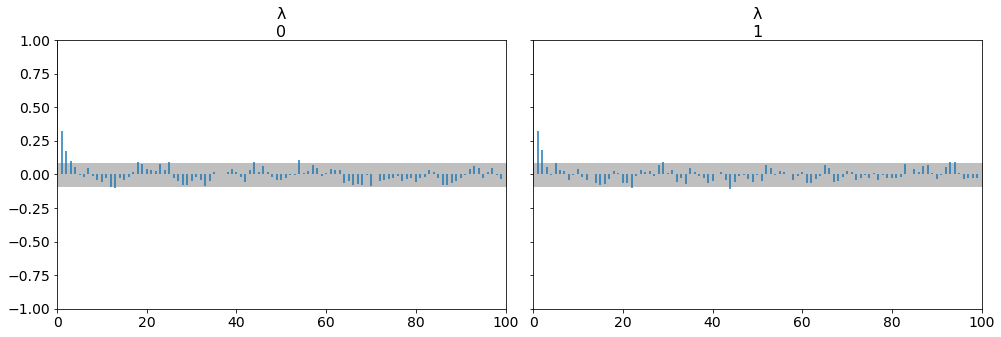

In [42]:
az.plot_autocorr(trace2)

Let's bump that up to 10,000 to see how the distribution looks, 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [λ]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 32 seconds.


array([[<AxesSubplot:title={'center':'λ'}>,
        <AxesSubplot:title={'center':'λ'}>]], dtype=object)

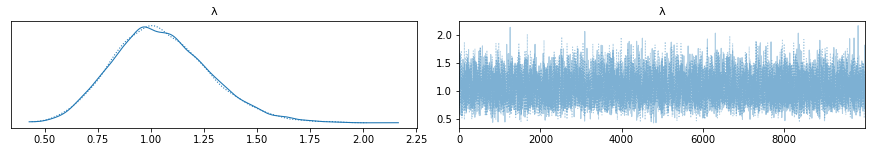

In [43]:
with model_2:
    trace3 = pm.sample(10000, tune=2000, cores=2, return_inferencedata=True)

az.plot_trace(trace3, var_names=['λ'])

We can see the posterior is pretty well defined, with a little skew right. Let's get the expected mean and credible interval:

In [44]:
az.summary(trace3, kind="stats")

,mean,sd,hdi_3%,hdi_97%
λ,1.048,0.229,0.62,1.468


The Bayesian in method in this case isnt much better than the MLE, but credible interval is more narrow than the confidence interval.

We can also see the mode of the posterior distribution is pretty much over 1.0 which is the correct value for our parameter.

Using the posterior mode is called the [Maximum A-Posteriori (MAP)](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) and we can see the calculated value below,
 

In [45]:
pm.find_MAP(model=model_2)

{'λ_log__': array(-1.70517194e-07), 'λ': array(0.99999983)}

That's really good for only 20 data points!! 

# Connecting The Two Methods <a class="anchor" id="sixth-bullet"></a>
------

Another way to rewrite Baye's formula is in terms of the Likelyhood functions, $L(\lambda \, \vert \,  y_1, y_2, \ldots, y_n)$


$$ P(\lambda \, \vert \, y_1, y_2, \ldots, y_n)
 \; = \; 
\frac{ L(\lambda \, \vert \,  y_1, y_2, \ldots, y_n) \, P(\lambda)}{m(y_1, y_2, \ldots, y_n)}
$$


Choosing a constant prior $C$ or uniform ($U(\theta)$ so long $\theta \, \geq \, \lambda$) the MAP is the same as the MLE:


$$ \max_{\lambda} \, P(\lambda \, \vert \, y_1, y_2, \ldots, y_n)
 \; = \; 
\frac{1}{m(y_1, y_2, \ldots, y_n)} \, \max_{\lambda} \, L(\lambda \, \vert \,  y_1, y_2, \ldots, y_n)
$$


We can show this by choosing the prior as a $U(10)$:

In [47]:
with pm.Model() as model_3:
    λ = pm.Uniform('λ', lower=0, upper=10)
    y = pm.Poisson('y', mu=λ, observed=list(sample[-20:-1]))
    
pm.find_MAP(model=model_3)

{'λ_interval__': array(-2.14006616), 'λ': array(1.05263158)}

This the the same value as the MLE! 

The [Bernstein-von Miss Theorem](
https://en.wikipedia.org/wiki/Bernstein%E2%80%93von_Mises_theorem) shows that in the limit of large data Bayesian estimators and Maximum Likelyhood estimators converge to the same thing.

In this post I covered maximum likelyhood estimators and Bayesian point estimators on data that was sampled using a Poisson distribution writen in Scala using [Py4J](https://www.py4j.org/).

I hope you enjoyed it!